## Load image and export non-overlapping rectangular regions (ROIs) to new image files

### IMPORTS
Requires cv2, numpy, matplotlib

In [235]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re  # regular expressions

In [236]:
### OPTIONS

In [237]:
DEBUGGING          =      True
doEXTERNALWINDOW   = False  # Don't make True if in GCP
doUSETESTIMAGERY   =      True
doTESTCOLOR        =      True

### Image path and filename
You need to define your inpath and filename (as infn) here.
This code is using a test image in a directory nearby that is defined as a relative path. 

In [238]:
if doUSETESTIMAGERY:
    # inpath = "./../../_TEST_IMAGERY/"
    inpath = "./../_TEST_IMAGERY/"
else:
    # inpath = "./../../Documents/_IMAGERY/"
    # inpath = "./../_IMAGERY/"
    inpath = "./../_IMAGERY/201004_MF_189_80_60_CB_S_1_360_64/"

if DEBUGGING & doUSETESTIMAGERY:
    if doTESTCOLOR:
        infn = "test-image-color.png"
    else: 
        infn = "real-big-image.tif"
else:
    infn = "201004_MF_189_80_60_CB_S_1_360_64.1+1.tif"

infile = inpath+infn
print( infile )

outpath = inpath+"REGIONS/"
print( outpath )


./../_TEST_IMAGERY/test-image-color.png


### Read the image

In [239]:
img = cv2.imread( infile )

### Image shape
Shape of image is accessed by img.shape. It returns a tuple of number of rows, columns and channels (if image is color):

In [240]:
print(img.shape)

(960, 1280, 3)


### Image size
Total number of pixels, from img.size

In [241]:
print(img.size)

3686400


### Image datatype
Image datatype 

In [242]:
print(img.dtype)

uint8


### Display image using cv2.imshow (creates external window)
DON'T DO THIS IN A JUPYTER NOTEBOOK

In [243]:
# displaying image using cv2.imshow (creates external window)
# DON'T DO THIS IN A JUPYTER NOTEBOOK
if doEXTERNALWINDOW:
    cv2.imshow('image window for img', img )
    #add wait key. window waits till user press any key
    cv2.waitKey(0)

### Some recommend to destroy all windows, but this causes error:
cv2.destoyAllWindows()
AttributeError: module 'cv2' has no attribute 'destoyAllWindows'

### __________________________________________________________________
### Load and display image in the notebook using matplotlib
Use matplotlib instead of opencv to read and display the image

(960, 1280, 3)
float32


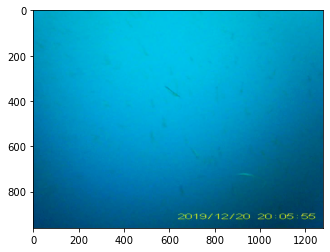

In [244]:
### Alternative: read the image in using matplotlib
imgplt= plt.imread( infile )
print(imgplt.shape)
print(imgplt.dtype)
plt.imshow(imgplt) # displays image in the next output cell of the jupyter notebook

### __________________________________________________________________
### Test iteration through image
Step through image by regions (ROIs, x,y blocks).
This will give you an idea how the code works, and demonstrate the process without saving the regions.

In [245]:
# TESTING 
ix      = 0
iy      = 0
iboxcount  = 0
intvpix = 200
NMAX    = 30

print( img.shape )
print( img.shape[0] )
print( img.shape[1] )

print('iboxcount, x, y' ) 
for x in range(     0, img.shape[0] , intvpix ):
    for y in range( 0, img.shape[1] , intvpix ):
        ix += 1
        iy += 1
        iboxcount += 1
        print( '%d %d %d (%d %d)' % (iboxcount, x, y, ix, iy) ) 
        print( img[x,y] )
         
        if iboxcount>NMAX:
            break
    if iboxcount>NMAX:
        break
   

(960, 1280, 3)
960
1280
iboxcount, x, y
1 0 0 (1 1)
[195 160   0]
2 0 200 (2 2)
[211 179   0]
3 0 400 (3 3)
[225 191   0]
4 0 600 (4 4)
[227 195   0]
5 0 800 (5 5)
[221 191   0]
6 0 1000 (6 6)
[198 173   0]
7 0 1200 (7 7)
[201 166   0]
8 200 0 (8 8)
[189 145   0]
9 200 200 (9 9)
[214 171   0]
10 200 400 (10 10)
[228 192   0]
11 200 600 (11 11)
[237 195   0]
12 200 800 (12 12)
[226 188   0]
13 200 1000 (13 13)
[208 165   0]
14 200 1200 (14 14)
[182 145   0]
15 400 0 (15 15)
[178 127   0]
16 400 200 (16 16)
[204 158   0]
17 400 400 (17 17)
[223 177   0]
18 400 600 (18 18)
[219 183   0]
19 400 800 (19 19)
[213 173   0]
20 400 1000 (20 20)
[194 152   0]
21 400 1200 (21 21)
[169 118   0]
22 600 0 (22 22)
[154 105   0]
23 600 200 (23 23)
[187 135   0]
24 600 400 (24 24)
[205 150   0]
25 600 600 (25 25)
[210 153   0]
26 600 800 (26 26)
[193 143   0]
27 600 1000 (27 27)
[165 118   0]
28 600 1200 (28 28)
[135  97   0]
29 800 0 (29 29)
[127  82   0]
30 800 200 (30 30)
[153 102   0]
31 800 400 (3

### __________________________________________________________________
## Export regions to images
This is the code that iterates through image by regions (ROIs, x,y blocks), 
and saves the regions to new image files. 

In [246]:
# Collect regions, don't export
       
ix = 0
iy = 0
icount    = 0
intvpix_x = 200
intvpix_y = 300
NROIMAX   = 5555555

if img.shape[0] <= intvpix_x:
    intvpix_x = 100
    intvpix_y = 100

print('icount, x, y' ) 
for x in range(     0, img.shape[0] - intvpix_x , intvpix_x ):
    for y in range( 0, img.shape[1] - intvpix_y , intvpix_y ):        
        ix += 1
        iy += 1
        icount += 1
        print('%d %d %d' % (icount, x, y) ) 
        print( img[x,y] )
        
        # region of interest rectangle selection
        ROI = img[ x:x+intvpix_x , y:y+intvpix_y ]
        
        if icount>NROIMAX:
            print('Breaking')
            break
    if icount>NROIMAX:
        print('Breaking')
        break
        

icount, x, y
1 0 0
[195 160   0]
2 0 300
[215 185   0]
3 0 600
[227 195   0]
4 0 900
[219 186   0]
5 200 0
[189 145   0]
6 200 300
[217 182   0]
7 200 600
[237 195   0]
8 200 900
[218 177   0]
9 400 0
[178 127   0]
10 400 300
[218 170   0]
11 400 600
[219 183   0]
12 400 900
[212 163   0]
13 600 0
[154 105   0]
14 600 300
[198 146   0]
15 600 600
[210 153   0]
16 600 900
[181 133   0]


In [247]:
# Check filenames 
       
ix = 0
iy = 0
icount = 0
# intvpix_x = 200
# intvpix_y = 300
boxx = 2000
boxy = 600
NROIMAX = 10000

print( img.shape[0] )
print( 'boxx init = %d' % boxx )    
print( boxx )

if img.shape[0] <= boxx:
    boxx    = 100
    boxy    = 100
    NROIMAX =  10

print( 'boxx now = %d' % boxx )    
    
print('icount, x, y' ) 
#for x in range(     0, img.shape[0] - boxx , boxx ):
#    for y in range( 0, img.shape[1] - boxy , boxy ):
for x in range(     0, img.shape[0]  , boxx ):
    for y in range( 0, img.shape[1]  , boxy ):  
        ix += 1
        iy += 1
        icount += 1
        #print('%d %d %d' % (icount, x, y) ) 
        print('%09d %d %d' % (icount, x, y) ) 
        print( img[x,y] )
        
        # region of interest rectangle selection
        ROI = img[ x:x+boxx , y:y+boxy ]
        
        # see existing infile name
        #leninfilename = len( infile )
        #print('infile = %s (len = %d)' % (infile, leninfilename) )  
        # remove extension ".***" using length of array minus lenght of ext
        #infile = infile[ 0:leninfilename-4  ]
        
        # remove extension using regular expressions, re.sub
        str2rep = ".png"
        # x = re.sub("\s", "9", txt, 2)
        infile = re.sub( str2rep , "", infile)
        print('[AFTER RE.SUB] infile = %s (len = %d)' % (infile, leninfilename) )  
        
        # outfilename
        #ofnpfx = infile+'_{}.png'
        # print( ofnpfx )
        #ofn = ofnpfx.format(icount, width=5)   # apparently the width option is not working here     

        ofnpfx = "%s_%06d.png" % (infile, icount) 
        print('!!ofnpfx!! = %s' % ofnpfx )
        
        # write region contents to image file (and works w/ color image content)
        # cv2.imwrite( ofn , ROI)
        
        if icount>NROIMAX:
            break
    if icount>NROIMAX:
        break
 

960
boxx init = 2000
2000
boxx now = 100
icount, x, y
000000001 0 0
[195 160   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000001.png
000000002 0 100
[200 171   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000002.png
000000003 0 200
[211 179   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000003.png
000000004 0 300
[215 185   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000004.png
000000005 0 400
[225 191   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000005.png
000000006 0 500
[222 193   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image

In [248]:

print( 'boxx init = %d' % boxx )    
print( boxx )


boxx init = 100
100


In [250]:
# Export regions to images 
       
ix = 0
iy = 0
icount = 0

boxx = 300
boxy = 300
NROIMAX = 10000

print(" img.shape[0] = %d" % img.shape[0]  )
print( 'boxx init = %d' % boxx )    
print( boxx )

if img.shape[0] <= boxx:
    boxx    = 100
    boxy    = 100
    NROIMAX =  10

print( 'boxx now = %d' % boxx )    
    
print('icount, x, y' ) 
#for x in range(     0, img.shape[0] - boxx , boxx ):
#    for y in range( 0, img.shape[1] - boxy , boxy ):
for x in range(     0, img.shape[0]  , boxx ):
    for y in range( 0, img.shape[1]  , boxy ):  
        ix += 1
        iy += 1
        icount += 1
        print('%d %d %d' % (icount, x, y) ) 
        print( img[x,y] )
        
        # region of interest rectangle selection
        ROI = img[ x:x+boxx , y:y+boxy ]
        
        # remove infilename extension using regular expressions, re.sub
        str2rep = ".png"
        # x = re.sub("\s", "9", txt, 2)
        infile = re.sub( str2rep , "", infile)
        print('[AFTER RE.SUB] infile = %s (len = %d)' % (infile, leninfilename) )  
                
        # outfilename
        ofn = "%s_%06d.png" % (infile, icount) 
        print('!!ofnpfx!! = %s' % ofn )
        
        # write region contents to image file (and works w/ color image content)
        cv2.imwrite( ofn , ROI)
        
        if icount>NROIMAX:
            break
    if icount>NROIMAX:
        break
 

 img.shape[0] = 960
boxx init = 300
300
boxx now = 300
icount, x, y
1 0 0
[195 160   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000001.png
2 0 300
[215 185   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000002.png
3 0 600
[227 195   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000003.png
4 0 900
[219 186   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000004.png
5 0 1200
[201 166   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000005.png
6 300 0
[185 138   0]
[AFTER RE.SUB] infile = ./../_TEST_IMAGERY/test-image-color (len = 35)
!!ofnpfx!! = ./../_TEST_IMAGERY/test-image-color_000006.png
7 300 300
[223 

In [187]:
print('N images = %d' % icount) 

N images = 11


Load and display image in the notebook using matplotlib

Use matplotlib instead of opencv to read and display the image


In [188]:
### Alternative: read the image in using matplotlib
infn = "201004_MF_189_80_60_CB_S_1_360_64.1+1.tif_1.png"
infile = inpath+infn
print( infile )

./../_TEST_IMAGERY/201004_MF_189_80_60_CB_S_1_360_64.1+1.tif_1.png


In [190]:
imgplt=plt.imread( infile )

print(imgplt.shape)

plt.imshow(imgplt) # displays image in the next output cell of the jupyter notebook

FileNotFoundError: [Errno 2] No such file or directory: './../_TEST_IMAGERY/201004_MF_189_80_60_CB_S_1_360_64.1+1.tif_1.png'